In [79]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
pd.set_option('display.max_rows',5)

In [80]:
movies_df = pd.read_csv('movies.csv',index_col=[0])
movies_df.head()


,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [81]:
ratings_df = pd.read_csv('ratings.csv',index_col=[0])
ratings_df.head()

,movieId,rating,timestamp
userId,,,
1,296,5.0,1147880044
1,306,3.5,1147868817
1,307,5.0,1147868828
1,665,5.0,1147878820
1,899,3.5,1147868510


In [82]:
tags_df = pd.read_csv('tags.csv',index_col=[0])
tags_df.head()


,movieId,tag,timestamp
userId,,,
3,260,classic,1439472355
3,260,sci-fi,1439472256
4,1732,dark comedy,1573943598
4,1732,great dialogue,1573943604
4,7569,so bad it's good,1573943455


In [83]:
genome_scores_df = pd.read_csv('genome-scores.csv',index_col=[0])
genome_scores_df.head()

,tagId,relevance
movieId,,
1,1,0.02875
1,2,0.02375
1,3,0.06250
1,4,0.07575
1,5,0.14075


In [84]:
genome_tags_df = pd.read_csv('genome-tags.csv',index_col=[0])
genome_scores_df.head()

,tagId,relevance
movieId,,
1,1,0.02875
1,2,0.02375
1,3,0.06250
1,4,0.07575
1,5,0.14075


In [85]:
links_df = pd.read_csv('links.csv',index_col=[0])
links_df.head()

,imdbId,tmdbId
movieId,,
1,114709,862.0
2,113497,8844.0
3,113228,15602.0
4,114885,31357.0
5,113041,11862.0


# NUMBER 1

In [86]:
mdf = movies_df.copy()

year = mdf['title'].str.findall('\((\d{4})\)').str.get(0)
mdf['year'] = year

mdf


## to check for genres, search in the index kung may genre na yun, then count, then eventually mag average?

,title,genres,year
movieId,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
2,Jumanji (1995),Adventure|Children|Fantasy,1995
...,...,...,...
209169,A Girl Thing (2001),(no genres listed),2001
209171,Women of Devil's Island (1962),Action|Adventure|Drama,1962


In [87]:
mdf['year'] = pd.to_numeric(mdf['year'], errors='coerce')

rp_Year = mdf.groupby(['year'])['title'].count().to_frame()
rp_Year.columns = ['movie/s'] 
rp_Year['change in releases (Percent)'] = rp_Year['movie/s'].pct_change()*100
rp_Year

,movie/s,change in releases (Percent)
year,,
1874.0,1,NaN
1878.0,1,0.000000
...,...,...
2018.0,2034,-14.321820
2019.0,994,-51.130777


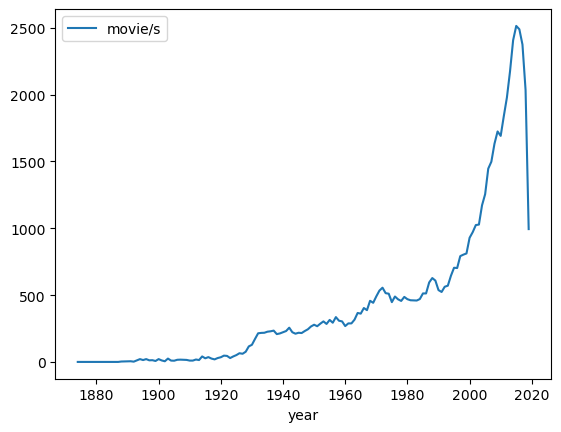

In [88]:
rpy = rp_Year.plot(y='movie/s',rot=0)

<AxesSubplot:xlabel='year'>

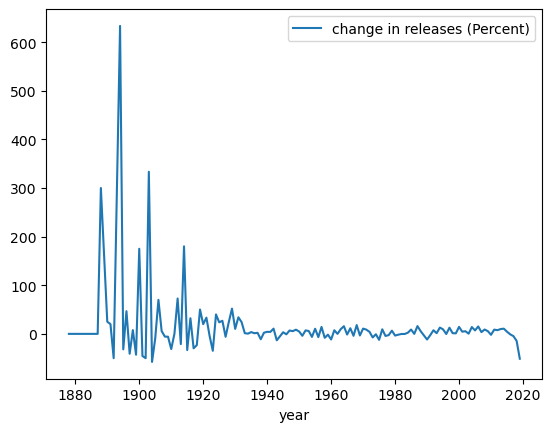

In [89]:
rp_Year.plot(y='change in releases (Percent)',rot=0)

The number of releases were low before the 1930's, rising gradually after that, and skyrocketing after the 1990's. However, the percentage of change in the number of releases stayed relatively constant from the 1930's onward, signifying exponential growth in the number of releases.

# NUMBER 2

What are the most popular genre of movies?


In [90]:
genre_df = mdf.copy()
genre_df['genres']=genre_df['genres'].str.split('|')
genre_df = genre_df.explode('genres')
genre_df

,title,genres,year
movieId,,,
1,Toy Story (1995),Adventure,1995.0
1,Toy Story (1995),Animation,1995.0
...,...,...,...
209171,Women of Devil's Island (1962),Adventure,1962.0
209171,Women of Devil's Island (1962),Drama,1962.0


In [91]:
r_df = ratings_df.copy()

mr_df = r_df.groupby(['movieId'])['rating'].mean()

mr_df

movieId
1         3.893708
2         3.251527
            ...   
209169    3.000000
209171    3.000000
Name: rating, Length: 59047, dtype: float64

In [92]:
merged = pd.merge(mr_df,genre_df, on='movieId')
genre_ratings= merged.groupby(['genres'])['rating'].mean()
genre_ratings = genre_ratings.to_frame()
genre_ratings.columns = ['average rating']
genre_ratings = genre_ratings.sort_values(by='average rating', ascending=False)
genre_ratings

,average rating
genres,
Documentary,3.382493
Film-Noir,3.318142
...,...
Sci-Fi,2.760530
Horror,2.650740


<AxesSubplot:xlabel='genres'>

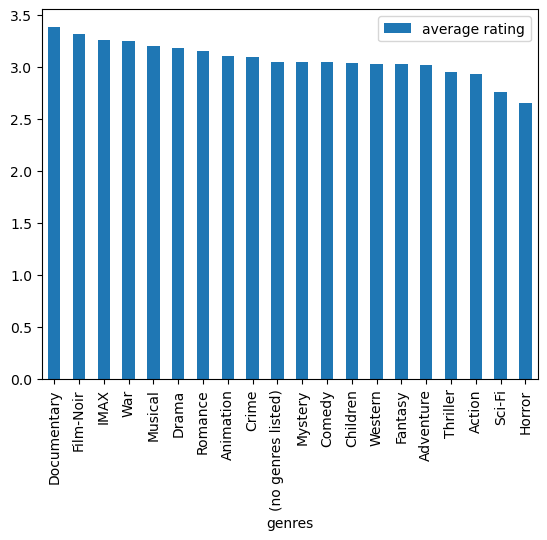

In [93]:
genre_ratings.plot.bar(y='average rating',rot=90)

The most popular genre of movies is documentary, followed by film-noir, IMAX, War, and Musical. 

# NUMBER 3

Does the taste of movies changes over time?

In [94]:
decade_genre_rate = merged.copy()
decade_genre_rate['decade']= pd.cut(decade_genre_rate['year'],np.arange(1869, 2020, 10), labels=['1870s', '1880s', '1890s',
                            '1900s', '1910s','1920s','1930s','1940s','1950s','1960s','1970s','1980s',
                                                                              '1990s','2000s','2010s'])

dgr = decade_genre_rate.groupby(['decade','genres'])['rating'].mean().to_frame()


pivot_dgr = dgr.pivot_table(index='decade',columns='genres',values='rating')

pdgr = pivot_dgr.copy()

plot_pdgr = pivot_dgr.copy()
plot_pdgr['decade']=pivot_dgr.index
plot_pdgr = plot_pdgr.reset_index(drop=True)
cols = plot_pdgr.columns.tolist()
cols = cols[-1:] + cols[:-1]
plot_pdgr = plot_pdgr[cols]

g_list = plot_pdgr.columns.to_list()

    
for i in range(len(g_list) - 1, -1, -1):
    if (g_list[i]== 'decade' or g_list[i]=='Documentary'or g_list[i]=='Film-Noir'or g_list[i]=='IMAX' 
        or g_list[i]=='War' or g_list[i] == 'Musical' ):
        del g_list[i]
        
plot_pdgr.drop(labels=g_list,axis=1,inplace=True)


In [95]:
#Tabulated data of average ratings of genres over the decade (note: 1 decade is 10 years, e.g. 1870 is 1870-1879)
pdgr

genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
decade,,,,,,,,,,,,,,,,,,,,
1870s,2.909091,NaN,NaN,NaN,NaN,NaN,NaN,3.027778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1880s,2.193182,NaN,NaN,NaN,NaN,NaN,NaN,2.431767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000s,3.010627,2.908030,2.950523,3.058930,2.901349,3.005531,3.095638,3.410153,3.151363,2.975191,3.270424,2.592622,3.284051,3.153986,3.027153,3.100240,2.777110,2.893199,3.249890,2.879840
2010s,3.176099,2.933045,2.987549,3.066554,3.039127,3.033780,3.110903,3.399634,3.188553,3.000664,3.124180,2.668152,3.225288,3.259440,3.050993,3.164712,2.819893,2.928169,3.190518,3.013517


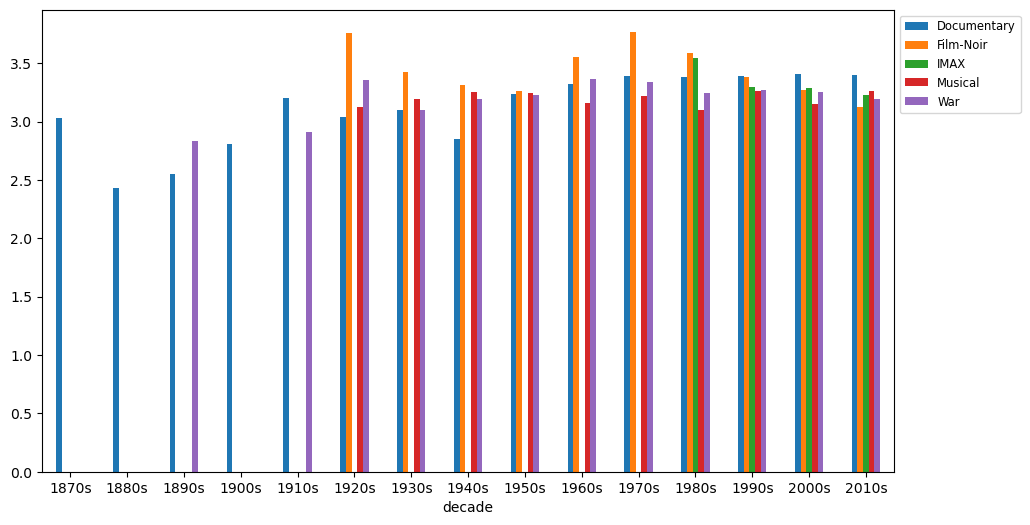

In [96]:
#clustered bar graph (note: only the top three genres were picked, according to table in number 2)
plot_pdgr.plot.bar(x='decade',rot=0,figsize=(11,6)).legend(
    bbox_to_anchor=(1.0, 1.0),
    fontsize='small',
)

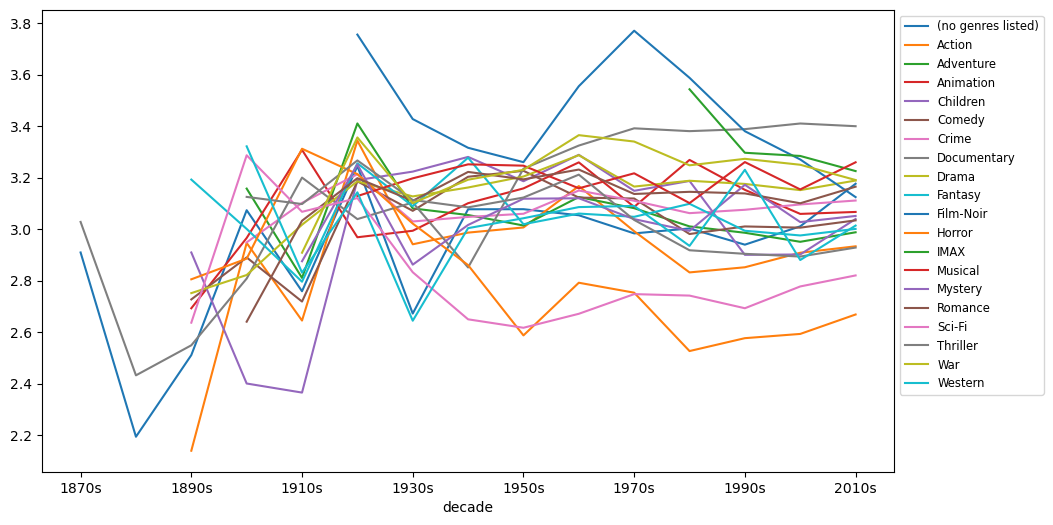

In [97]:
pdgr.plot(figsize=(11,6)).legend(
    bbox_to_anchor=(1.0, 1.0),
    fontsize='small',
)

In [98]:
year_genre_rate = merged.groupby(['year','genres'])['rating'].mean().to_frame()
pivot_ygr = year_genre_rate.pivot_table(index='year',columns='genres',values='rating')

#pd.set_option('display.max_rows', None)
#remove comment to see table
pivot_ygr

genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
year,,,,,,,,,,,,,,,,,,,,
1874.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.027778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1878.0,2.909091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018.0,2.951294,2.909679,2.832463,3.000088,2.731482,2.968518,3.063526,3.313467,3.144468,2.707949,NaN,2.563853,NaN,NaN,2.963035,3.138135,2.701121,2.893557,3.343366,2.829340
2019.0,2.368979,2.696809,2.720166,2.868197,2.856216,2.679549,2.823347,2.958223,2.759569,2.803967,NaN,2.232229,NaN,NaN,2.852543,2.829436,2.497187,2.540989,2.612769,2.063752


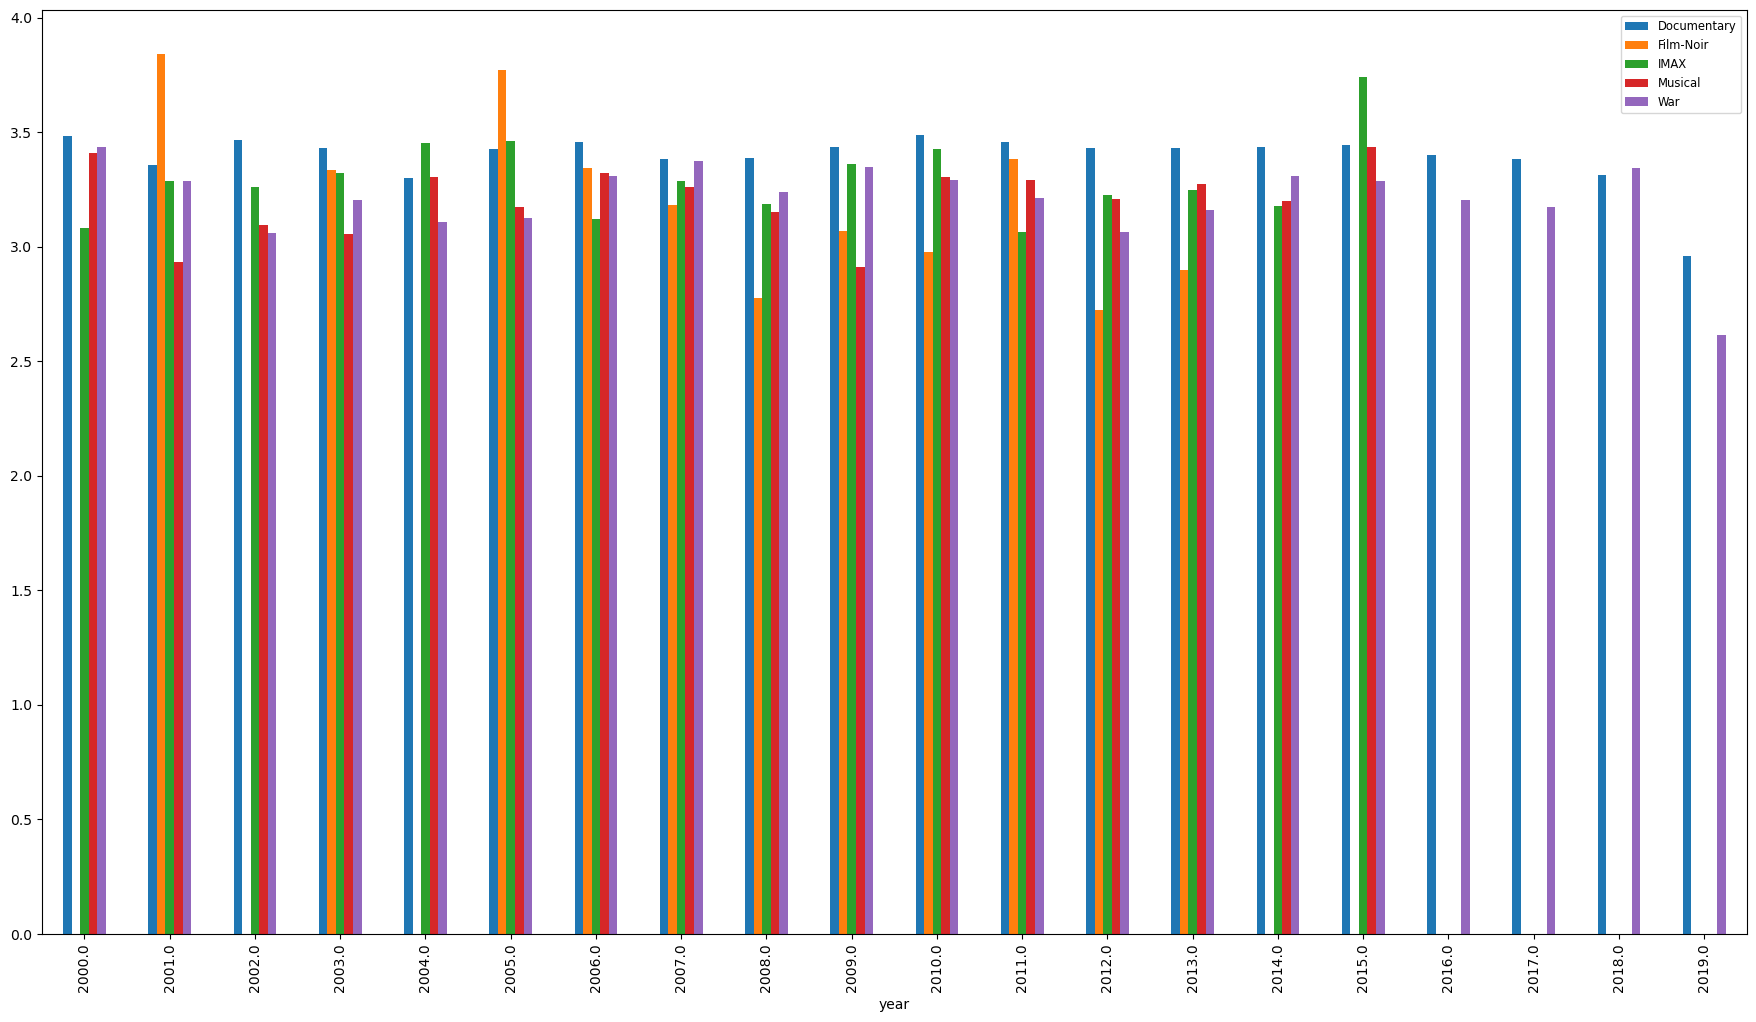

In [99]:
plot_pygr = pivot_ygr[pivot_ygr.index >= 2000].copy()

plot_pygr.drop(labels=g_list,axis=1,inplace=True)

plot_pygr.plot.bar(figsize=(22,12)).legend(
    bbox_to_anchor=(1.0, 1.0),
    fontsize='small',
)

#ratings of overall top 5 genres throughout 2000-2019

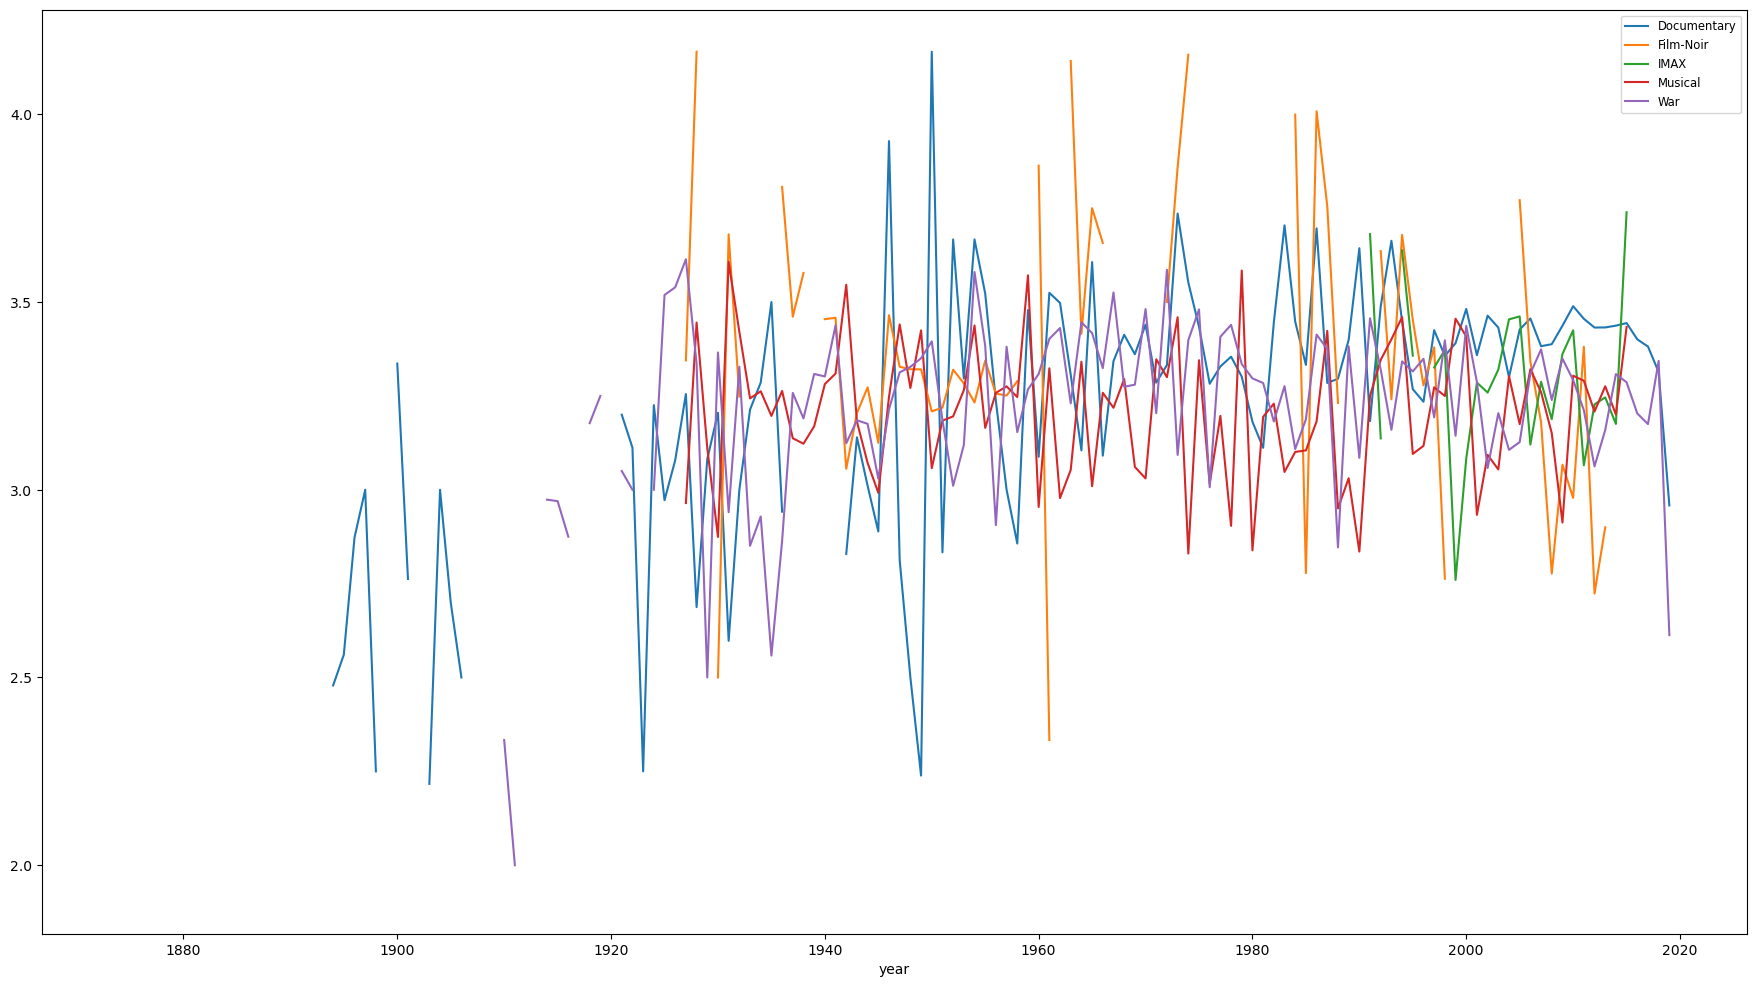

In [100]:
#throughout the year, with only the top 5 genres
pygr = pivot_ygr.copy()
pygr.drop(labels=g_list,axis=1,inplace=True)
pygr.plot(figsize=(22,12)).legend(
    bbox_to_anchor=(1.0, 1.0),
    fontsize='small',
)

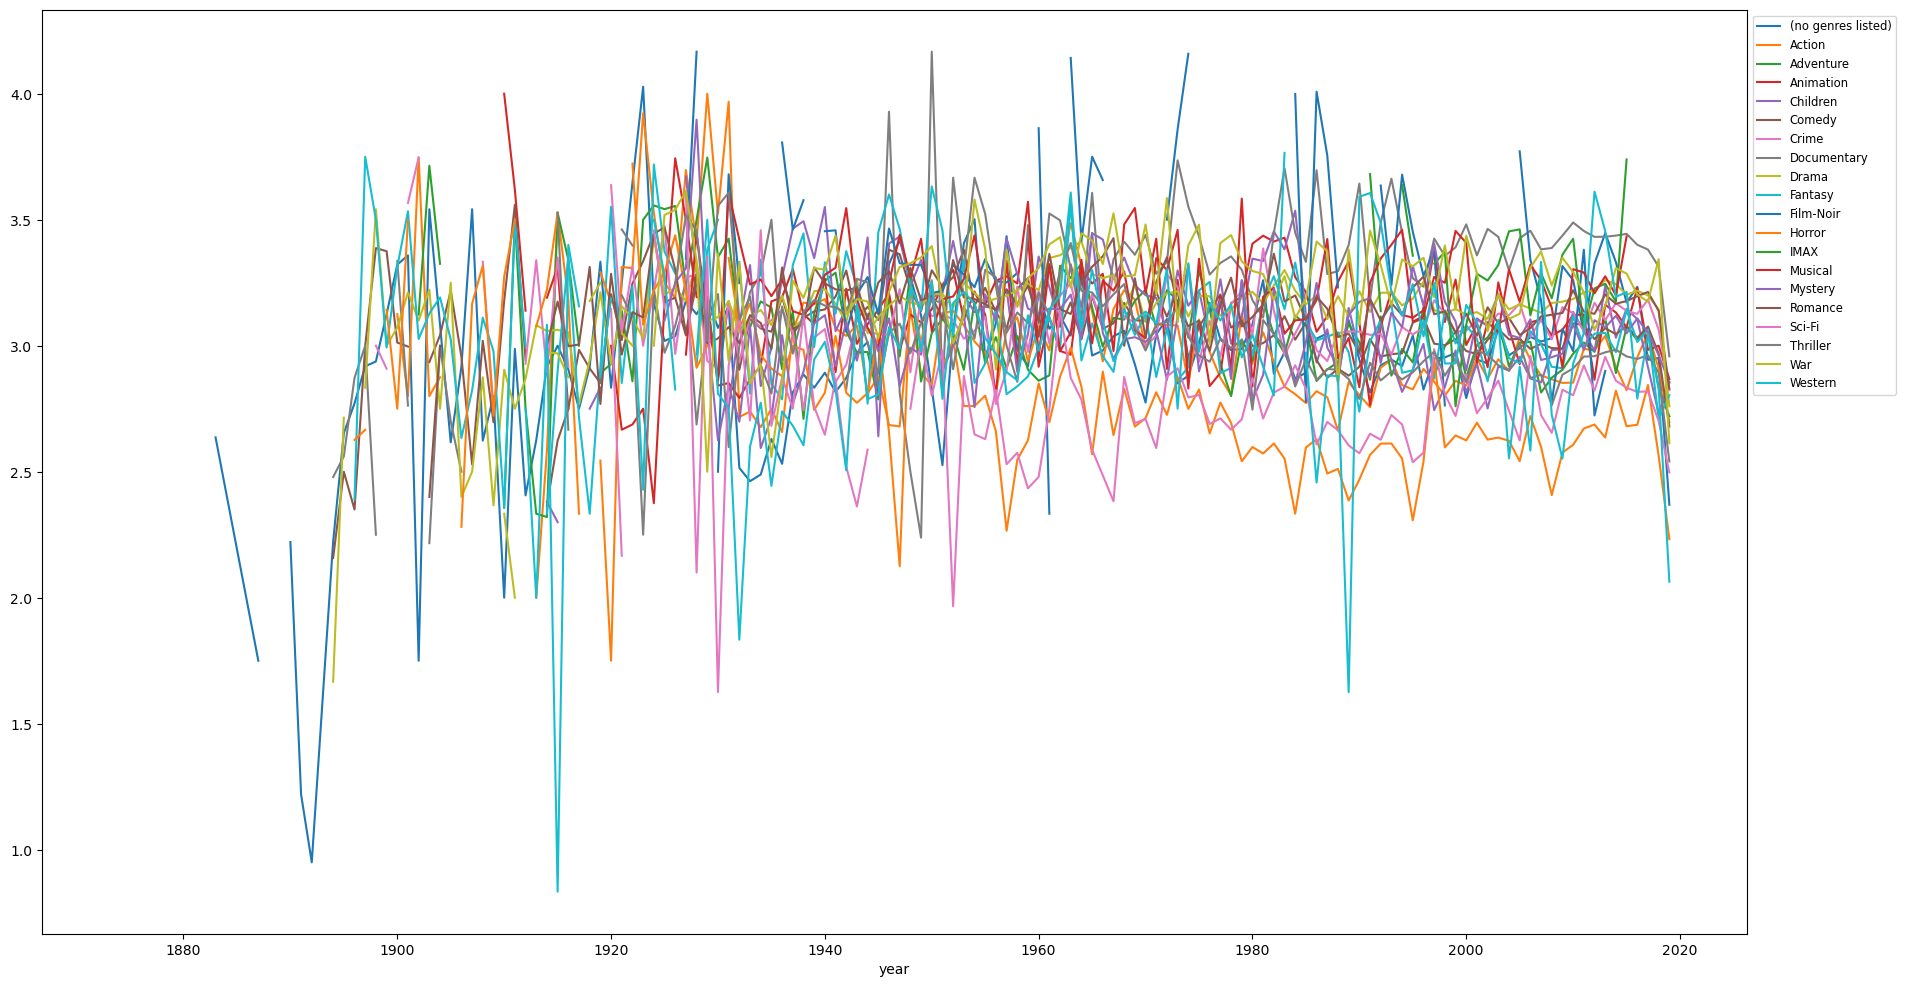

In [101]:
#all the years, with all genres
pivot_ygr.plot(figsize=(22,12)).legend(
    bbox_to_anchor=(1.0, 1.0),
    fontsize='small',
)

There was some change in the popularity of movies, but interest in the top genres stayed somewhat the same throughout the years.

# Number 4

What are the top 20 movies that has the top amount of users rating and has the highest rate?

In [23]:
rdf = ratings_df.copy()
rdf['userId']=rdf.index
rdf = rdf.reset_index(drop=True)
colum = rdf.columns.tolist()
colum = colum[-1:] + colum[:-1]
rdf = rdf[colum]

m_r = pd.merge(rdf,mdf,on='movieId')
m_r

,userId,movieId,rating,timestamp,title,genres,year
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1994.0
1,3,296,5.0,1439474476,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1994.0
...,...,...,...,...,...,...,...
25000093,162386,200726,4.0,1554651417,The Graduates (1995),Children|Drama,1995.0
25000094,162386,200728,4.0,1554651472,Il pesce innamorato (1999),(no genres listed),1999.0


In [24]:
count_mr = m_r.groupby(['title'])['rating'].agg(['count','mean']).sort_values(by='count',ascending=False)
count_mr.columns=['Number of Ratings','Average Rating']
top_twnty_votes = count_mr.head(20)
top_twnty_votes
#top 20 movies in terms of number of ratings

,Number of Ratings,Average Rating
title,,
Forrest Gump (1994),81491,4.048011
"Shawshank Redemption, The (1994)",81482,4.413576
...,...,...
"Godfather, The (1972)",52498,4.324336
"Lord of the Rings: The Two Towers, The (2002)",51138,4.068051


In [25]:
#top 20 movies based on number of ratings sorted by average rating
t_twnty_v = top_twnty_votes.sort_values(by='Average Rating',ascending=False)
t_twnty_v

,Number of Ratings,Average Rating
title,,
"Shawshank Redemption, The (1994)",81482,4.413576
"Godfather, The (1972)",52498,4.324336
...,...,...
Toy Story (1995),57309,3.893708
Jurassic Park (1993),64144,3.679175


In [26]:
#top 20 in terms of average ratings
ave_mr = m_r.groupby(['title']).rating.agg(['mean','count']).sort_values(by='mean',ascending=False)
ave_mr.columns = ['Average Rating','Number of Ratings']
amr = ave_mr.head(20)
amr


,Average Rating,Number of Ratings
title,,
Full of Grace (2015),5.0,1
Geordie (1955),5.0,1
...,...,...
Ghost (2010),5.0,1
Ghostline (2015),5.0,1


<AxesSubplot:xlabel='title'>

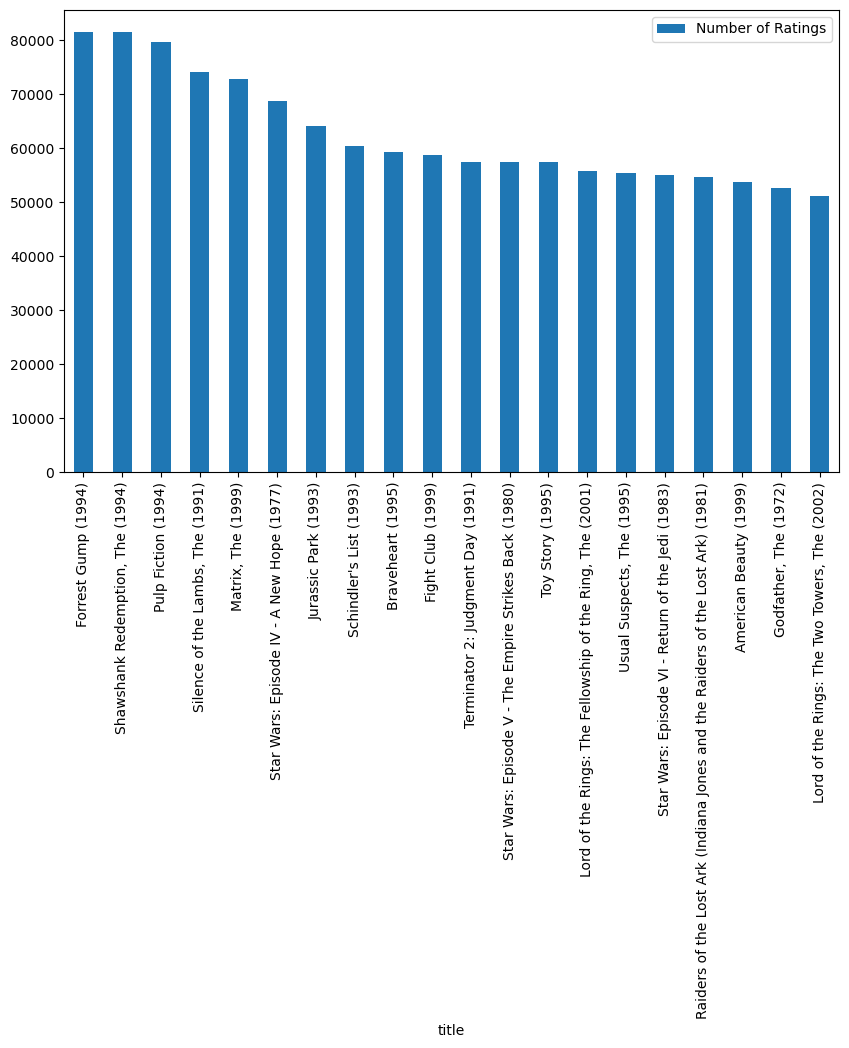

In [27]:
#graph of top 20 movies in terms of number of ratings
top_twnty_votes.plot.bar(y='Number of Ratings',figsize=(10,6))

<AxesSubplot:xlabel='title'>

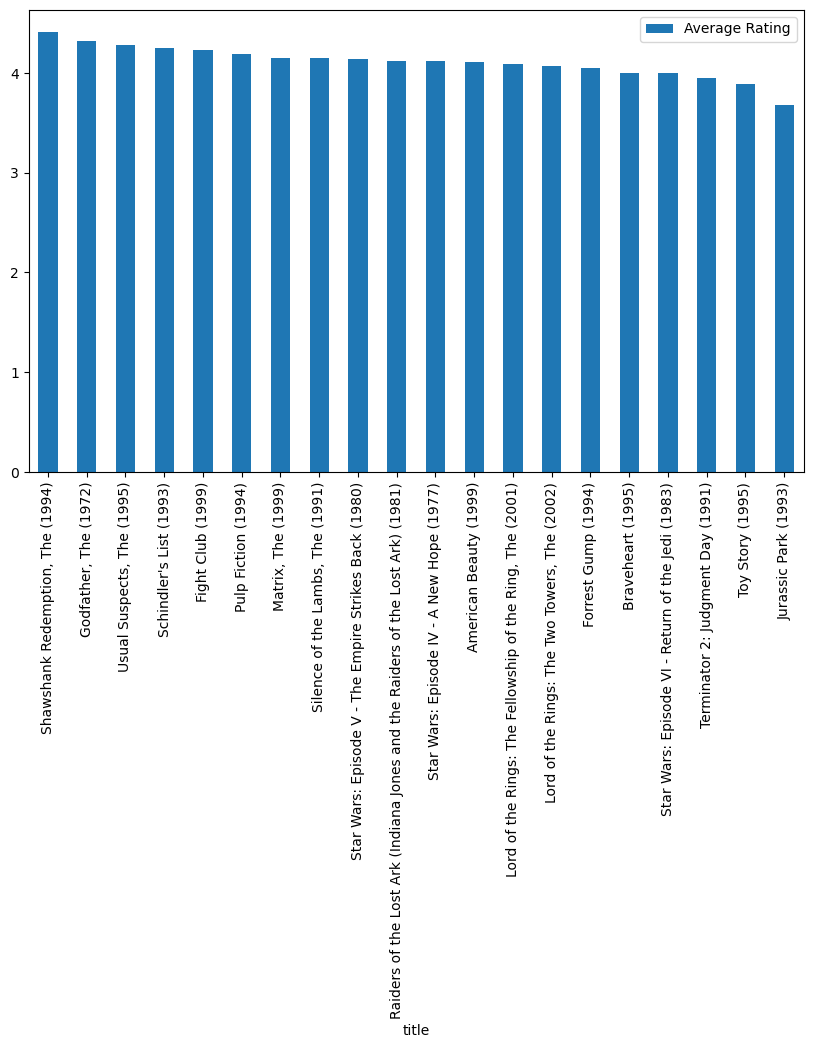

In [28]:
#graph of top 20 movies based on number of ratings sorted by average rating
t_twnty_v.plot.bar(y='Average Rating',figsize=(10,6))

<AxesSubplot:xlabel='title'>

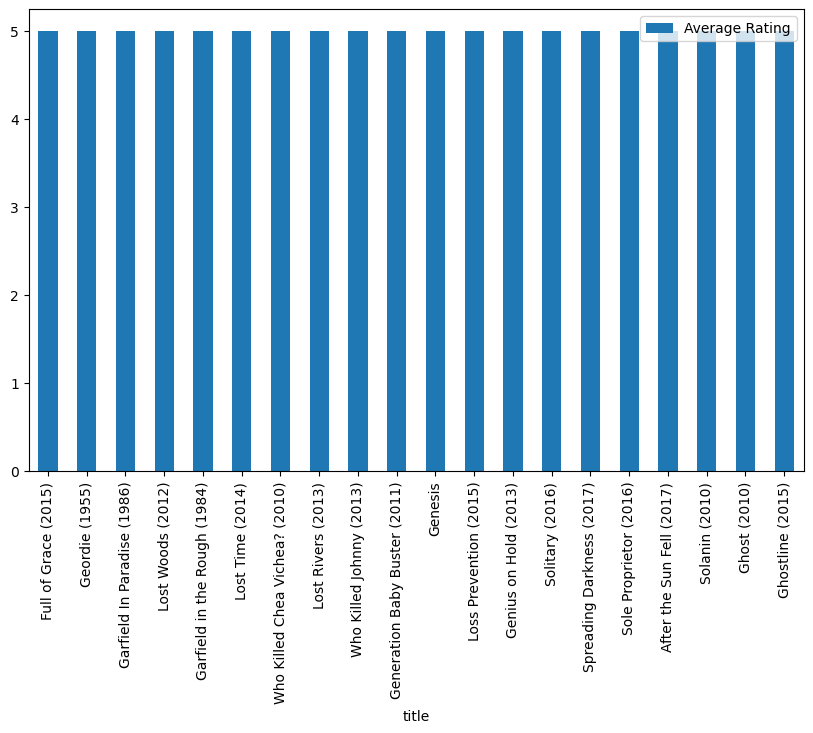

In [29]:
#graph of top 20 movies based on number of ratings sorted by average rating
amr.plot.bar(y='Average Rating',figsize=(10,6))

# Number 5

What is the most of popular season for releasing movies?

In [24]:
time_mov = pd.concat([ratings_df,tags_df])

time_mov['date'] = pd.to_datetime(time_mov['timestamp'],unit='s')

time_mov['season'] = time_mov['date'].dt.month%12 // 3 + 1
time_mov['season'] = time_mov['season'].replace([1, 2, 3,4], ['winter', 'spring', 'summer','fall'])
time_mov

,movieId,rating,timestamp,tag,date,season
userId,,,,,,
1,296,5.0,1147880044,NaN,2006-05-17 15:34:04,spring
1,306,3.5,1147868817,NaN,2006-05-17 12:26:57,spring
...,...,...,...,...,...,...
162534,189169,NaN,1527518181,disabled,2018-05-28 14:36:21,spring
162534,189169,NaN,1527518193,robbery,2018-05-28 14:36:33,spring


In [45]:
c_smv = time_mov.groupby(['season'])['movieId'].count().to_frame()
c_smv.columns = ['Count of Interactions']
csmv = c_smv.sort_values(by='Count of Interactions',ascending=False)
csmv

,Count of Interactions
season,
fall,6589315
summer,6535369
winter,6522430
spring,6446341


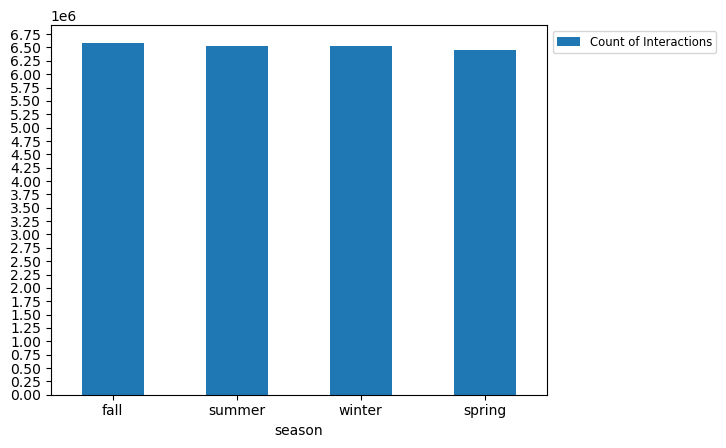

In [50]:
csmv.plot.bar(rot=0,yticks=np.arange(0,7000000,250000)).legend(
    bbox_to_anchor=(1.0, 1.0),
    fontsize='small',
)


barely any difference, but technically, fall is the most popular season, and is the best time to release movies.